## Import Package

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import csv

In [ ]:
# mount my google drive
from google.colab import drive
from os import listdir, mkdir
from os.path import isfile, join, exists
drive.mount('/content/gdrive/')
folder = '/content/gdrive/My Drive/FinTechFinal/Data'
print(listdir(folder))


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
['stock_info_1.csv', 'txn_2019H1.zip', 'txn_2019H2.zip', 'txn_2020H1.zip', 'txn_2020H2.zip', 'stock_info.zip', 'stock_category.csv', 'txn_2021Q1.csv', 'stock_info_2021Q1.csv', 'stock_category.xlsx', 'cust_info_1.csv', '檔案說明_20200423.xlsx', 'txn_2019H1', 'models', 'cust_txn_result_final.csv', 'result.csv']


In [ ]:
# Read Data
custom_info = pd.read_csv(join(folder, "cust_info_1.csv"))
custom_info.head()

txn = pd.read_csv(join(folder, "cust_txn_result_final.csv"))

# To Chris , custom_info add two column: 交易量 & 散戶==1 非散戶==2 
# Got it, thanks a lot
custom_info = pd.merge(custom_info,txn,on='cust',how='left')
custom_info.head()

,cust,age_level,open_acct_year,source_code,breach_ind,breach_date,breach_rank,investment_exp_code,buy_cnt,sell_cnt,nontxn_cnt,txn_amount,cust_size
0,0xDB5D3FF6B7FE584CAE62A6C482194282E627EE8F9BBB...,3,2018,B,1,560.0,1.0,2.0,26.0,24.0,5.0,617670.0,1.0
1,0x1879388A362A9CE3DB27F651C333F9BF4B66460538CF...,4,2016,B,1,556.0,1.0,3.0,95.0,81.0,1.0,255890.0,1.0
2,0x78D069BCC23EAD3DF21154E5C04838C7F942ACD422BB...,3,2020,A,1,555.0,1.0,0.0,7.0,1.0,0.0,90320.2,1.0
3,0x2E5D5882D3FA49E0B552A4C481F43307F854246B918B...,3,2020,B,1,552.0,1.0,0.0,19.0,14.0,2.0,1982480.0,1.0
4,0x6711C00180B590285AB040EAAB3EB9D1F7704BA2B4CE...,2,2020,B,1,546.0,1.0,0.0,6.0,3.0,3.0,31783.2,1.0


# Regression

In [ ]:

#normalize
# max_year = custom_info["open_acct_year"].max()
# min_year = custom_info["open_acct_year"].min()
# custom_info["open_acct_year"] = (custom_info["open_acct_year"] - min_year)/(max_year - min_year)
# max_buy = data_selected["buy_cnt"].max()
# min_buy = data_selected["buy_cnt"].min()
# data_selected["buy_cnt"] = (data_selected["buy_cnt"] - min_buy)/(max_buy - min_buy)
# max_sell = data_selected["sell_cnt"].max()
# min_sell = data_selected["sell_cnt"].min()
# data_selected["sell_cnt"] = (data_selected["sell_cnt"] - min_sell)/(max_sell - min_sell)
# Set input, output
data_selected = custom_info[["age_level", "open_acct_year", "buy_cnt", "sell_cnt", "breach_ind", "cust_size"]] #全部使用的欄位

data_selected = data_selected.dropna() #drop missing data

X = data_selected[["age_level", "open_acct_year", "buy_cnt", "sell_cnt", "cust_size"]] # input的欄位
y = data_selected["breach_ind"]


# Split data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
y_train = pd.DataFrame(y_train).reset_index(drop=True)
y_positvie  = y_train[y_train['breach_ind'] == 1]
X_train = X_train.reset_index(drop=True)
X_positvie = X_train.iloc[list(y_positvie.index)]
X_positvie = pd.concat([X_positvie]*(int(len(X_train) /len(X_positvie))), ignore_index = True)
X_train = pd.concat([X_positvie, X_train], ignore_index=True)
y_positvie = pd.concat([y_positvie]*(int(len(y_train) /len(y_positvie))), ignore_index = True)
y_train = pd.concat([y_positvie, y_train], ignore_index=True)
y_train = y_train['breach_ind']

In [ ]:
clf_logistic=linear_model.LogisticRegression(class_weight= {0:47,1:55})
clf_logistic.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight={0: 47, 1: 55}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

score: 0.6880833166433006
report:
               precision    recall  f1-score   support

      breach       0.00      0.79      0.00        14
  not breach       1.00      0.69      0.82     24951

    accuracy                           0.69     24965
   macro avg       0.50      0.74      0.41     24965
weighted avg       1.00      0.69      0.81     24965



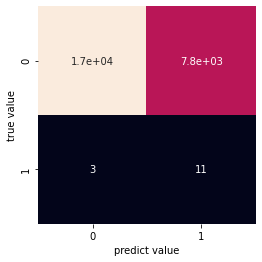

In [ ]:
y_predict = clf_logistic.predict(X_test) 

mat = confusion_matrix(y_test,y_predict)
print("score:",clf_logistic.score(X_test,y_test))
  
# 查看recall，及f1-score
print("report:\n",classification_report(y_test,y_predict,labels=[1,0],target_names=["breach","not breach"])) # target_names可自定義，但要對應label傳入的目標值的順序

# 顯示confusion matrix
sns.heatmap(mat,square=True,annot=True,cbar=False)
plt.xlabel("predict value")
plt.ylabel("true value")
plt.show()

# print(y_predict.head
# print(y_predict.index[y_predict.iloc[:, 0] == 1].tolist())
# print(y_test.iloc[12262])


In [ ]:
predict = clf_logistic.predict(custom_info[["age_level", "open_acct_year", "buy_cnt", "sell_cnt", "cust_size"]].dropna() )
result = pd.DataFrame()
result['cust'] =custom_info.dropna()['cust']
result['result'] = pd.DataFrame(predict)
result.to_csv(join(folder, 'result.csv'))
print(result.head())

                                                cust  result
0  0xDB5D3FF6B7FE584CAE62A6C482194282E627EE8F9BBB...       1
1  0x1879388A362A9CE3DB27F651C333F9BF4B66460538CF...       0
2  0x78D069BCC23EAD3DF21154E5C04838C7F942ACD422BB...       1
3  0x2E5D5882D3FA49E0B552A4C481F43307F854246B918B...       1
4  0x6711C00180B590285AB040EAAB3EB9D1F7704BA2B4CE...       1
